# k-Means Clustering
## This notebook is a presentation on how to implement clustering for optimization in different datasets

In [64]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np

## Introducing k-Means

The *k*-means algorithm searches for a pre-determined number of clusters within an unlabeled multidimensional dataset.
It accomplishes this using a simple conception of what the optimal clustering looks like:

- The "cluster center" is the arithmetic mean of all the points belonging to the cluster.
- Each point is closer to its own cluster center than to other cluster centers.

Those two assumptions are the basis of the *k*-means model.
We will soon dive into exactly *how* the algorithm reaches this solution, but for now let's take a look at a simple dataset and see the *k*-means result.

For the purpose of this demonstration, we will use the inbuilt datasets within the sklearn library
1. Iris dataset
2. Text
3. China image

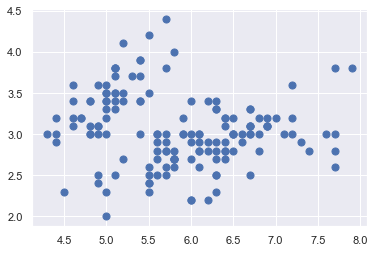

In [65]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data[:, :2]  # we only take the first two features.
y = iris.target
plt.scatter(X[:, 0], X[:, 1], s=50);

It is relatively easy to pick out the four main clusters.
The *k*-means algorithm does this automatically, and in Scikit-Learn uses the typical estimator API:

In [66]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
print(y_kmeans)

[0 2 2 2 0 0 2 0 2 2 0 2 2 2 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 2 2 0 0 0 2 2 0
 0 2 0 0 2 2 0 0 2 0 2 0 2 3 3 3 1 3 1 3 2 3 2 2 1 1 1 1 3 1 1 1 1 1 1 1 1
 1 3 3 3 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 2 1 1 1 1 2 1 3 1 3 1 3 3 2 3 3 3 3
 1 3 1 1 3 3 3 3 1 3 1 3 1 3 3 1 1 1 3 3 3 1 1 1 3 3 3 1 3 3 3 1 3 3 3 1 3
 1 1]


Let's visualize the results by plotting the data colored by these labels.
We will also plot the cluster centers as determined by the *k*-means estimator:

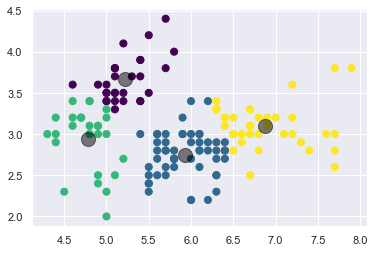

In [67]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

## k-Means Algorithm: Expectation–Maximization

Expectation–maximization (E–M) is a powerful algorithm that is used in clustering applications.
*k*-means is a particularly effective clustering algorithm, and it is explained briefly here.
In short, the expectation–maximization approach here consists of the following procedure:

1. Guess some cluster centers
2. Repeat until converged
   1. *E-Step*: assign points to the nearest cluster center
   2. *M-Step*: set the cluster centers to the mean 

Here the "E-step" or "Expectation step" is so-named because it involves updating our expectation of which cluster each point belongs to.
The "M-step" or "Maximization step" is so-named because it involves maximizing some fitness function that defines the location of the cluster centers—in this case, that maximization is accomplished by taking a simple mean of the data in each cluster.

[47  3 31 25]


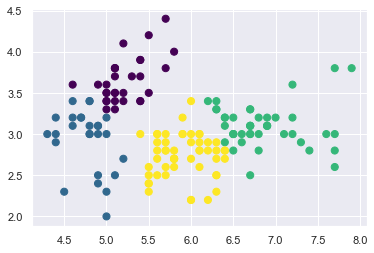

In [68]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=3):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    print(i)
    centers = X[i]

    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

### Caveats of expectation–maximization

There are a few issues to be aware of when using the expectation–maximization algorithm.

#### The globally optimal result may not be achieved
First, although the E–M procedure is guaranteed to improve the result in each step, there is no assurance that it will lead to the *global* best solution.
For example, if we use a different random seed in our simple procedure, the particular starting guesses lead to poor results:

[114  62  33 107]


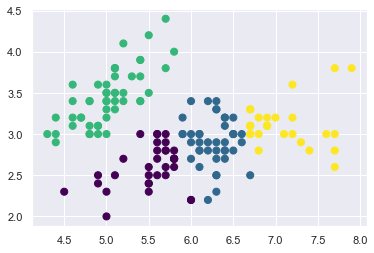

In [69]:
centers, labels = find_clusters(X, 4, rseed=0)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis');

Here the E–M approach has converged, but has not converged to a globally optimal configuration. For this reason, it is common for the algorithm to be run for multiple starting guesses, as indeed Scikit-Learn does by default (set by the ``n_init`` parameter, which defaults to 10).

#### The number of clusters must be selected beforehand
Another common challenge with *k*-means is that you must tell it how many clusters you expect: it cannot learn the number of clusters from the data.
For example, if we ask the algorithm to identify six clusters, it will happily proceed and find the best six clusters:

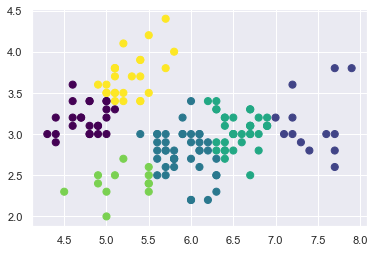

In [70]:
labels = KMeans(6, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

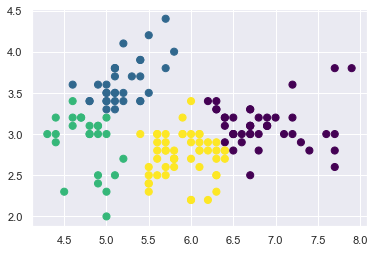

In [71]:
labels = KMeans(4, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

#### k-means is limited to linear cluster boundaries
The fundamental model assumptions of *k*-means (points will be closer to their own cluster center than to others) means that the algorithm will often be ineffective if the clusters have complicated geometries.

In particular, the boundaries between *k*-means clusters will always be linear, which means that it will fail for more complicated boundaries.
Consider the following data, along with the cluster labels found by the typical *k*-means approach:

In [72]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)

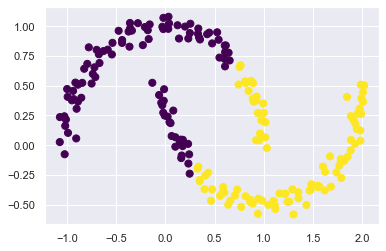

In [73]:
labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

This situation is similar to the implementation of Support Vector Machines, where a kernel transformation is usedto project the data into a higher dimension where a linear separation is possible.

One version of this kernelized *k*-means is implemented in Scikit-Learn within the ``SpectralClustering`` estimator.
It uses the graph of nearest neighbors to compute a higher-dimensional representation of the data, and then assigns labels using a *k*-means algorithm:

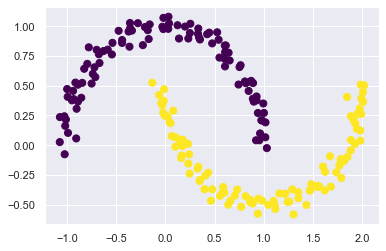

In [74]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

With this kernel transform approach, the kernelized *k*-means is able to find the more complicated nonlinear boundaries between clusters.

#### k-means can be slow for large numbers of samples
Because each iteration of *k*-means must access every point in the dataset, the algorithm can be relatively slow as the number of samples grows. To improve the processing time, the processing can be done in batches.
The idea behind batch-based *k*-means algorithms, one form of which is implemented in ``sklearn.cluster.MiniBatchKMeans``.
The interface for this is the same as for standard ``KMeans``.

### k-means on digits for Unsupervised Learning

Here we will attempt to use *k*-means to try to identify similar digits *without using the original label information*; this might be similar to a first step in extracting meaning from a new dataset about which you don't have any *a priori* label information.

We will start by loading the digits and then finding the ``KMeans`` clusters.
Recall that the digits consist of 1,797 samples with 64 features, where each of the 64 features is the brightness of one pixel in an 8×8 image:

In [75]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

The clustering can be performed as we did before:

In [76]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

The result is 10 clusters in 64 dimensions.
Notice that the cluster centers themselves are 64-dimensional points, and can themselves be interpreted as the "typical" digit within the cluster.

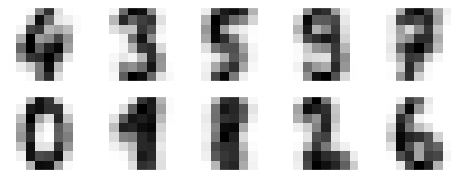

In [77]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

*Even without the labels*, ``KMeans`` is able to find clusters whose centers are recognizable digits.

Because *k*-means knows nothing about the identity of the cluster, the 0–9 labels may be permuted.
We can fix this by matching each learned cluster label with the true labels found in them:

In [78]:
from scipy.stats import mode
#print(clusters)
labels = np.zeros_like(clusters)
#print(clusters.shape)
for i in range(10):
    #print(i)
    mask = (clusters == i)
    #print(mask.shape)
    labels[mask] = mode(digits.target[mask])[0]
    #print(labels)

Now we can check how accurate our unsupervised clustering was in finding similar digits within the data:

In [79]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.7935447968836951

With just a simple *k*-means clustering algorithm, the correct grouping is achieved for 80% of the input digits.
The confusion matrix for this would be:

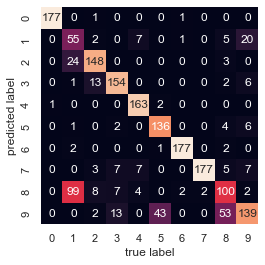

In [80]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

As we might expect from the cluster centers we visualized before, the main point of confusion is between the eights and ones.
But this still shows that using *k*-means, we can essentially build a digit classifier *without reference to any known labels*!

To make this even more accurate we can use the t-distributed stochastic neighbor embedding (t-SNE) algorithm to pre-process the data before performing *k*-means clustering.
t-SNE is a nonlinear embedding algorithm that is particularly adept at preserving points within clusters.

In [81]:
from sklearn.manifold import TSNE

# Project the data: this step will take several seconds
tsne = TSNE(n_components=2, init='random', random_state=0)
digits_proj = tsne.fit_transform(digits.data)

# Compute the clusters
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits_proj)

# Permute the labels
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

# Compute the accuracy
accuracy_score(digits.target, labels)

0.9432387312186978

That's nearly 95% classification accuracy *without using the labels*.
Unsupervised learning when used carefully can extract information from the dataset that it might be difficult to do by hand or by eye.

### Example 2: *k*-means for color compression

One interesting application of clustering is in color compression within images.
For example, imagine you have an image with millions of colors.
In most images, a large number of the colors will be unused, and many of the pixels in the image will have similar or even identical colors.

For example, consider the image shown in the following figure, which is from the Scikit-Learn ``datasets`` module (for this to work, you'll have to have the ``pillow`` Python package installed).

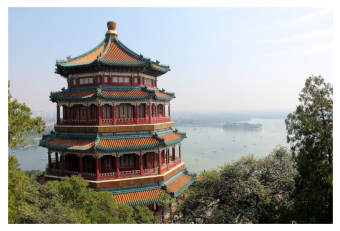

In [82]:
# This requires the ``pillow`` package to be installed
# !pip install pillow
# uncomment the line above if running this cell for the first time

from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china);

The image itself is stored in a three-dimensional array of size ``(height, width, RGB)``, containing red/blue/green contributions as integers from 0 to 255:

In [83]:
china.shape

(427, 640, 3)

One way we can view this set of pixels is as a cloud of points in a three-dimensional color space.
We will reshape the data to ``[n_samples x n_features]``, and rescale the colors so that they lie between 0 and 1:

In [84]:
data = china / 255.0 # use 0...1 scale
data = data.reshape(427 * 640, 3)
data.shape

(273280, 3)

We can visualize these pixels in this color space, using a subset of 10,000 pixels for efficiency:

In [85]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);

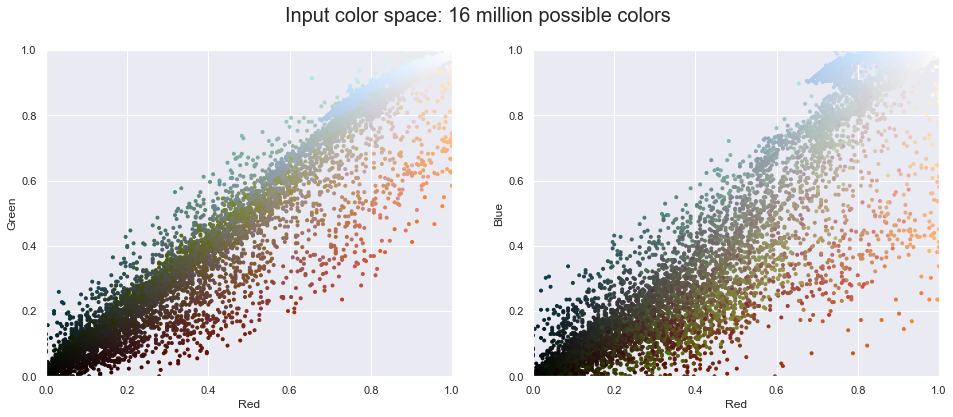

In [86]:
plot_pixels(data, title='Input color space: 16 million possible colors')

Now let's reduce these 16 million colors to just 16 colors, using a *k*-means clustering across the pixel space.
Because we are dealing with a very large dataset, we will use the mini batch *k*-means, which operates on subsets of the data to compute the result much more quickly than the standard *k*-means algorithm:

(16, 3)
2.6050541400909424


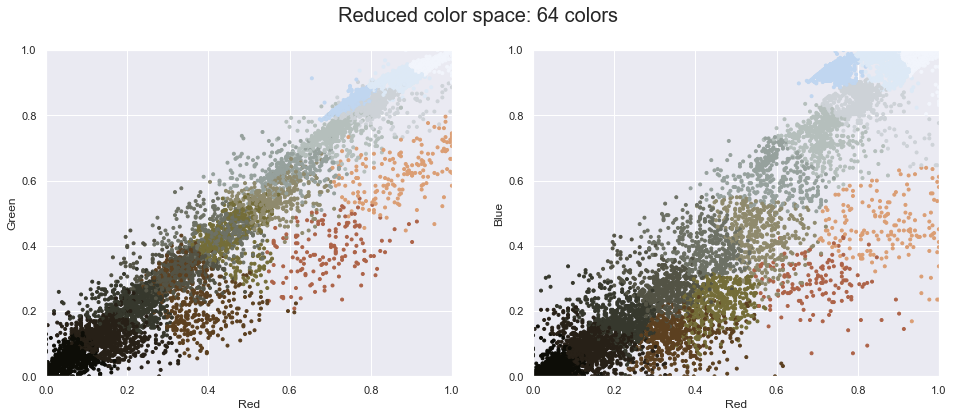

In [87]:
import warnings; warnings.simplefilter('ignore')

from sklearn.cluster import MiniBatchKMeans
#kmeans = MiniBatchKMeans(16)
import time
start = time.time()
"the code you want to test stays here"
k_colors = KMeans(n_clusters=16).fit(data)
y_pred=k_colors.predict(data) 
print(k_colors.cluster_centers_.shape)

new_colors=k_colors.cluster_centers_[k_colors.labels_]

#kmeans.fit(data)
#new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors=new_colors,
            title="Reduced color space: 64 colors")

end = time.time()
print(end - start)

0.2584819793701172


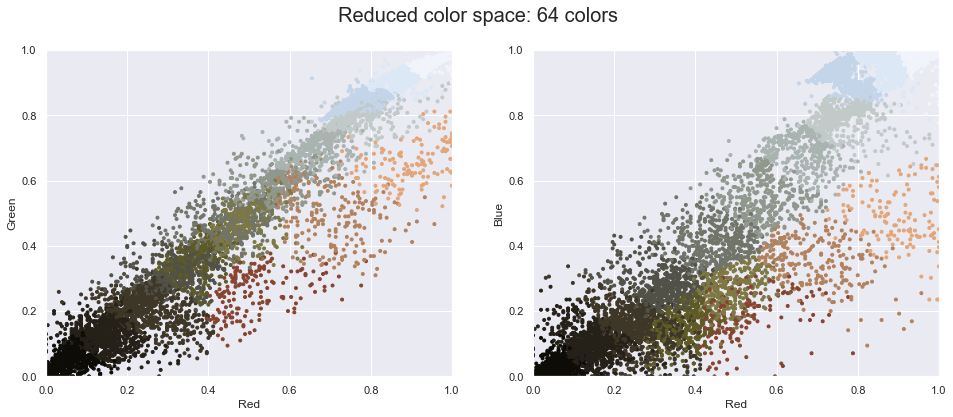

In [88]:
start = time.time()
kmeans = MiniBatchKMeans(16).fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors=new_colors,
            title="Reduced color space: 64 colors")

end = time.time()
print(end - start)

The result is a re-coloring of the original pixels, where each pixel is assigned the color of its closest cluster center.
Plotting these new colors in the image space rather than the pixel space shows us the effect of this:

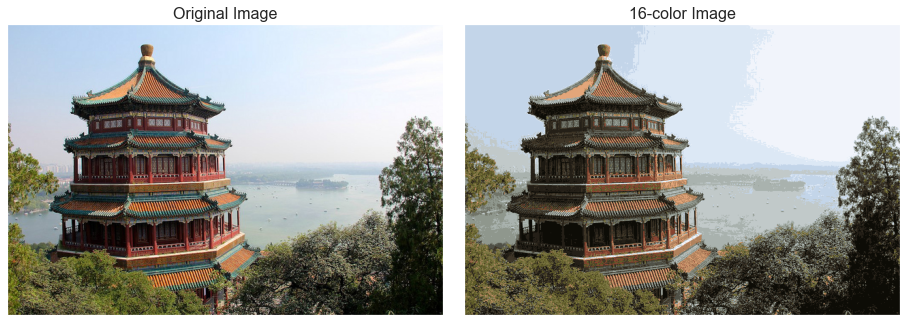

In [89]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('16-color Image', size=16);

Some detail are certainly lost in the rightmost panel, but the overall image is still easily recognizable.
This image on the right achieves a compression factor of around 1 million.
While this is an interesting application of *k*-means, there are certainly better way to compress information in images.
But the example shows the power of using clustering algorithms with unsupervised methods like *k*-means.